In [4]:
#importamos las librerias necesarias
import numpy as np #manipulacion matematica
import pyeeg as pe #funciones para frecuencia, especificamente en eeg
import pickle as pickle #para descomprimir archivos
import pandas as pd #manipulacion de dataframes
import math #math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm #importamos suport vector machine para probar el modelo
from sklearn.preprocessing import normalize, LabelEncoder #normalizacion de datos
from sklearn.ensemble import RandomForestRegressor #random forest para prediccion de datos
from sklearn.ensemble import RandomForestClassifier #random forest para prediccion de datos
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
from statistics import mean

import os #comunicacion con equipo operativo
#import tensorflow as tf
import time #control de tiempo

In [5]:
channels = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

def valores(array):
    converted_array = np.where(array < 3.6, 0, np.where(array > 6.3, 2, 1))
    return converted_array

In [6]:
with open('out\data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('out\label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])

Arousal_Train_Class = valores(Arousal_Train)
Valence_Train_Class = valores(Valence_Train)
Domain_Train_Class = valores(Domain_Train)

with open('out\data_validation.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('out\label_validation.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

label_encoder = LabelEncoder()

def testing (M, L, model):
    '''
    arguments:  M: testing dataset
                L: testing dataset label
                model: scikit-learn model

    return:     void
    '''
    output = model.predict(M[0:78080:32])
    label = L[0:78080:32]

    k = 0
    l = 0

    for i in range(len(label)):
        k = k + (output[i] - label[i])*(output[i] - label[i]) #square difference 

        #a good guess
        if (output[i] > 5 and label[i] > 5):
            l = l + 1
        elif (output[i] < 5 and label[i] <5):
            l = l + 1

    print ("l2 error:", k/len(label), "classification accuracy:", l / len(label),l, len(label))

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])

Arousal_Test_Class = valores(Arousal_Test)
Valence_Test_Class = valores(Valence_Test)
Domain_Test_Class = valores(Domain_Test)

In [7]:
#Feature Engineering
df = pd.DataFrame(X)

df.columns = ['Fp1_Delta', 'Fp1_Theta', 'Fp1_Alpha','Fp1_Beta','Fp1_Gamma',
              'Fp2_Delta', 'Fp2_Theta', 'Fp2_Alpha','Fp2_Beta','Fp2_Gamma',
              'C3_Delta', 'C3_Theta', 'C3_Alpha','C3_Beta','C3_Gamma',
              'C4_Delta', 'C4_Theta', 'C4_Alpha','C4_Beta','C4_Gamma',
              'P7_Delta', 'P7_Theta', 'P7_Alpha','P7_Beta','P7_Gamma',
              'P8_Delta', 'P8_Theta', 'P8_Alpha','P8_Beta','P8_Gamma',
              'O1_Delta', 'O1_Theta', 'O1_Alpha','O1_Beta','O1_Gamma',
              'O2_Delta', 'O2_Theta', 'O2_Alpha','O2_Beta','O2_Gamma',]

for channel in channels:
    df[f'{channel}_Engagement'] = df[f'{channel}_Beta'] / (df[f'{channel}_Theta'] + df[f'{channel}_Alpha'])

for channel in channels:
    df[f'{channel}_Fatigue'] = df[f'{channel}_Alpha'] / df[f'{channel}_Theta']

for channel in channels:
    df[f'{channel}_Excitement'] = df[f'{channel}_Beta'] / df[f'{channel}_Alpha']

for channel in channels:
    df[f'{channel}_Relaxation'] = df[f'{channel}_Theta'] / df[f'{channel}_Delta']


In [8]:
#Feature Engineering
df_pred = pd.DataFrame(M)

df_pred.columns = ['Fp1_Delta', 'Fp1_Theta', 'Fp1_Alpha','Fp1_Beta','Fp1_Gamma',
                   'Fp2_Delta', 'Fp2_Theta', 'Fp2_Alpha','Fp2_Beta','Fp2_Gamma',
                   'C3_Delta', 'C3_Theta', 'C3_Alpha','C3_Beta','C3_Gamma',
                   'C4_Delta', 'C4_Theta', 'C4_Alpha','C4_Beta','C4_Gamma',
                   'P7_Delta', 'P7_Theta', 'P7_Alpha','P7_Beta','P7_Gamma',
                   'P8_Delta', 'P8_Theta', 'P8_Alpha','P8_Beta','P8_Gamma',
                   'O1_Delta', 'O1_Theta', 'O1_Alpha','O1_Beta','O1_Gamma',
                   'O2_Delta', 'O2_Theta', 'O2_Alpha','O2_Beta','O2_Gamma',]

for channel in channels:
    df_pred[f'{channel}_Engagement'] = df_pred[f'{channel}_Beta'] / (df_pred[f'{channel}_Theta'] + df_pred[f'{channel}_Alpha'])

for channel in channels:
    df_pred[f'{channel}_Fatigue'] = df_pred[f'{channel}_Alpha'] / df_pred[f'{channel}_Theta']

for channel in channels:
    df_pred[f'{channel}_Excitement'] = df_pred[f'{channel}_Beta'] / df_pred[f'{channel}_Alpha']

for channel in channels:
    df_pred[f'{channel}_Relaxation'] = df_pred[f'{channel}_Theta'] / df_pred[f'{channel}_Delta']


In [ ]:
#Entrenamiento de Regresores

#Val_R = RandomForestRegressor(n_estimators=512, n_jobs=6)
#Val_R.fit(X[0:468480:16], Valence_Train[0:468480:16])

#Aro_R = RandomForestRegressor(n_estimators=512, n_jobs=6)
#Aro_R.fit(X[0:468480:16], Arousal_Train[0:468480:16])   

#Dom_R = RandomForestRegressor(n_estimators=512, n_jobs=6)
#Dom_R.fit(X[0:468480:16], Domain_Train[0:468480:16])


In [12]:
#Entrenamiento de Clasificadores RF

Val_RF = RandomForestClassifier(n_estimators=512, n_jobs=6)
Val_RF.fit(df[0:468480:8], Valence_Train_Class[0:468480:8])

Aro_RF = RandomForestClassifier(n_estimators=512, n_jobs=6)
Aro_RF.fit(df[0:468480:8], Arousal_Train_Class[0:468480:8])

Dom_RF = RandomForestClassifier(n_estimators=512, n_jobs=6)
Dom_RF.fit(df[0:468480:8], Domain_Train_Class[0:468480:8])

RandomForestClassifier(n_estimators=512, n_jobs=6)

In [ ]:
#Entrenamiento de Clasificadores SVM

Val_SVM = SVC(kernel='linear', C=1.0, random_state=42)
Val_SVM.fit(df[0:468480:16], Valence_Train_Class[0:468480:16])

Aro_SVM = SVC(kernel='linear', C=1.0, random_state=42)
Aro_SVM.fit(df[0:468480:16], Arousal_Train_Class[0:468480:16])

Dom_SVM = SVC(kernel='linear', C=1.0, random_state=42)
Dom_SVM.fit(df[0:468480:16], Domain_Train_Class[0:468480:16])

In [ ]:
#Entrenamiento de Clasificadores XGBOOST

Val_XGB = xgb.XGBClassifier(random_state=42)
Val_XGB.fit(df[0:468480:16], Valence_Train_Class[0:468480:16])

Aro_XGB = xgb.XGBClassifier(random_state=42)
Aro_XGB.fit(df[0:468480:16], Arousal_Train_Class[0:468480:16])

Dom_XGB = xgb.XGBClassifier(random_state=42)
Dom_XGB.fit(df[0:468480:16], Domain_Train_Class[0:468480:16])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
'''importances = Val_R2.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. Feature {index}: Importance = {importances[index]}")

threshold = 0.028
selected_indices = np.where(importances >= threshold)[0]
selected_features = X[:, selected_indices]'''

'importances = Val_R2.feature_importances_\nindices = np.argsort(importances)[::-1]\nprint("Feature ranking:")\nfor i, index in enumerate(indices):\n    print(f"{i + 1}. Feature {index}: Importance = {importances[index]}")\n\nthreshold = 0.028\nselected_indices = np.where(importances >= threshold)[0]\nselected_features = X[:, selected_indices]'

In [ ]:
'''#predicciones regresor
val_pred = Val_R.predict(M[0:74240:512])
aro_pred = Aro_R.predict(M[0:74240:512])
dom_pred = Dom_R.predict(M[0:74240:512])'''

'#predicciones regresor\nval_pred = Val_R.predict(M[0:74240:512])\naro_pred = Aro_R.predict(M[0:74240:512])\ndom_pred = Dom_R.predict(M[0:74240:512])'

In [ ]:
'''fig, ax = plt.subplots()
ax.plot(Valence_Test[0:74240:512], label='Real Values')
ax.plot(val_pred, label='Predicted Values')
plt.xlim(100,150)
plt.title('Valence Real vs Predicted')
plt.legend()'''

"fig, ax = plt.subplots()\nax.plot(Valence_Test[0:74240:512], label='Real Values')\nax.plot(val_pred, label='Predicted Values')\nplt.xlim(100,150)\nplt.title('Valence Real vs Predicted')\nplt.legend()"

In [ ]:
'''fig, ax = plt.subplots()
ax.plot(Arousal_Test[0:74240:512], label='Real Values')
ax.plot(aro_pred, label='Predicted Values')
plt.xlim(100,150)
plt.title('Arousal Real vs Predicted')
plt.legend()'''

"fig, ax = plt.subplots()\nax.plot(Arousal_Test[0:74240:512], label='Real Values')\nax.plot(aro_pred, label='Predicted Values')\nplt.xlim(100,150)\nplt.title('Arousal Real vs Predicted')\nplt.legend()"

In [ ]:
'''fig, ax = plt.subplots()
ax.plot(Domain_Test[0:74240:16], label='Real Values')
ax.plot(dom_pred, label='Predicted Values')
plt.xlim(100,150)
plt.title('Dominance Real vs Predicted')
plt.legend()'''

"fig, ax = plt.subplots()\nax.plot(Domain_Test[0:74240:16], label='Real Values')\nax.plot(dom_pred, label='Predicted Values')\nplt.xlim(100,150)\nplt.title('Dominance Real vs Predicted')\nplt.legend()"

In [ ]:
'''#r2_score, mean_absolute_error, mean_squared_error
r2_val = r2_score(Valence_Test[0:74240:512], val_pred)
print("R-squared Score Valence:", r2_val)
r2_aro = r2_score(Arousal_Test[0:74240:512], aro_pred)
print("R-squared Score Arousal:", r2_aro)
r2_dom = r2_score(Domain_Test[0:74240:512], dom_pred)
print("R-squared Score Dominance:", r2_dom)

mae_val = mean_absolute_error(Valence_Test[0:74240:512], val_pred)
print("Mean Absolute Error Valence:", mae_val)
mae_aro = mean_absolute_error(Arousal_Test[0:74240:512], aro_pred)
print("Mean Absolute Error Arousal:", mae_aro)
mae_dom = mean_absolute_error(Domain_Test[0:74240:512], dom_pred)
print("Mean Absolute Error Dominance:", mae_dom)'''

'#r2_score, mean_absolute_error, mean_squared_error\nr2_val = r2_score(Valence_Test[0:74240:512], val_pred)\nprint("R-squared Score Valence:", r2_val)\nr2_aro = r2_score(Arousal_Test[0:74240:512], aro_pred)\nprint("R-squared Score Arousal:", r2_aro)\nr2_dom = r2_score(Domain_Test[0:74240:512], dom_pred)\nprint("R-squared Score Dominance:", r2_dom)\n\nmae_val = mean_absolute_error(Valence_Test[0:74240:512], val_pred)\nprint("Mean Absolute Error Valence:", mae_val)\nmae_aro = mean_absolute_error(Arousal_Test[0:74240:512], aro_pred)\nprint("Mean Absolute Error Arousal:", mae_aro)\nmae_dom = mean_absolute_error(Domain_Test[0:74240:512], dom_pred)\nprint("Mean Absolute Error Dominance:", mae_dom)'

In [13]:
#predicciones clasificador
val_class_RF = Val_RF.predict(df_pred[0:74240])
aro_class_RF = Aro_RF.predict(df_pred[0:74240])
dom_class_RF = Dom_RF.predict(df_pred[0:74240])

acc_val_RF = accuracy_score(Valence_Test_Class[0:74240], val_class_RF)
acc_aro_RF = accuracy_score(Arousal_Test_Class[0:74240], aro_class_RF)
acc_dom_RF = accuracy_score(Domain_Test_Class[0:74240], dom_class_RF)

print("Valence Random Forest Accuracy: ", acc_val_RF)
print("Arousal Random Forest Accuracy: ", acc_aro_RF)
print("Dominance Random Forest Accuracy: ", acc_dom_RF)

Valence Random Forest Accuracy:  0.9610112028301887
Arousal Random Forest Accuracy:  0.963561320754717
Dominance Random Forest Accuracy:  0.9646521226415095


([<matplotlib.axis.YTick at 0x23ab48b7880>,
 [Text(0, 0.5, 'Low Dominance'),
  Text(0, 1.5, 'Mid Dominance'),
  Text(0, 2.5, 'High Dominance')])

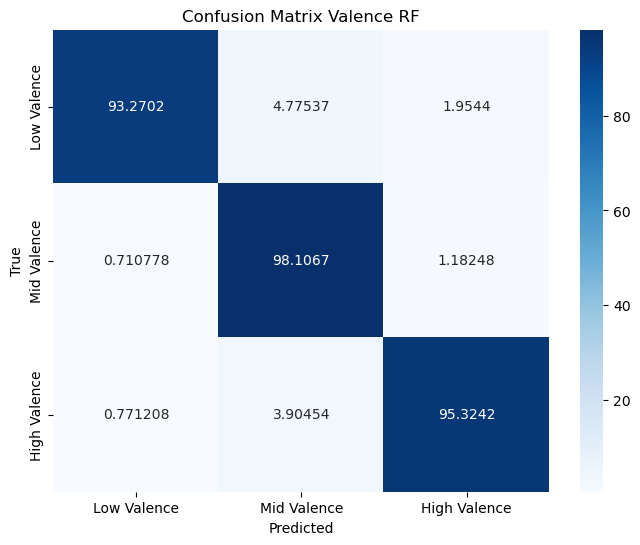

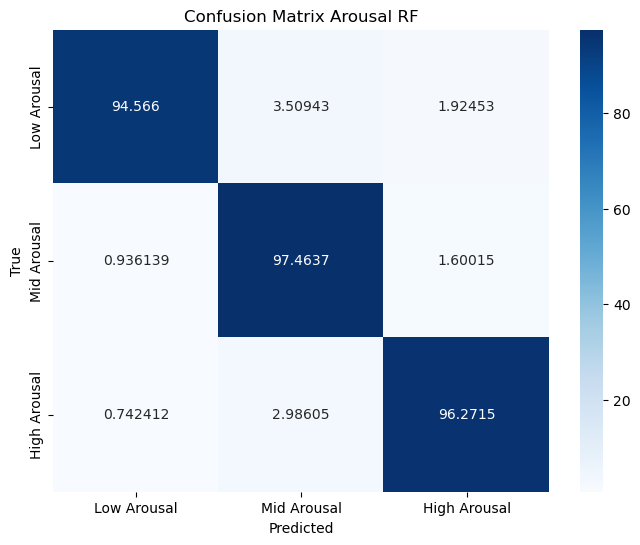

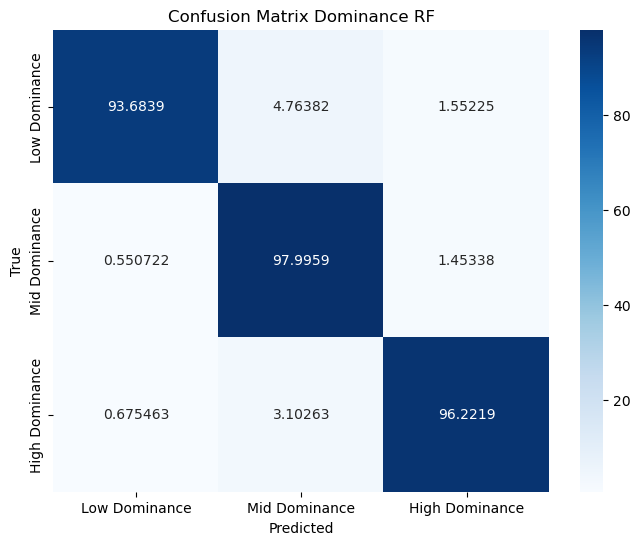

In [15]:
cm_val_RF = confusion_matrix(Valence_Test_Class[0:74240], val_class_RF)
plt.figure(figsize=(8, 6))
row_sum_val_RF = cm_val_RF.sum(axis=1)
cm_val_percent_RF = (cm_val_RF / row_sum_val_RF[:, np.newaxis]) * 100
sns.heatmap(cm_val_percent_RF, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Valence RF')
class_names = ['Low Valence', 'Mid Valence', 'High Valence']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_aro_RF = confusion_matrix(Arousal_Test_Class[0:74240], aro_class_RF)
plt.figure(figsize=(8, 6))
row_sum_aro_RF = cm_aro_RF.sum(axis=1)
cm_aro_percent_RF = (cm_aro_RF / row_sum_aro_RF[:, np.newaxis]) * 100
sns.heatmap(cm_aro_percent_RF, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Arousal RF')
class_names = ['Low Arousal', 'Mid Arousal', 'High Arousal']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_dom_RF = confusion_matrix(Domain_Test_Class[0:74240], dom_class_RF)
plt.figure(figsize=(8, 6))
row_sum_dom_RF = cm_dom_RF.sum(axis=1)
cm_dom_percent_RF = (cm_dom_RF / row_sum_dom_RF[:, np.newaxis]) * 100
sns.heatmap(cm_dom_percent_RF, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Dominance RF')
class_names = ['Low Dominance', 'Mid Dominance', 'High Dominance']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [17]:
report_val_RF = classification_report(Valence_Test_Class[0:74240], val_class_RF)
print("Classification Report Valence RF:")
print(report_val_RF)

report_aro_RF = classification_report(Arousal_Test_Class[0:74240], aro_class_RF)
print("Classification Report Arousal RF:")
print(report_val_RF)

report_dom_RF = classification_report(Domain_Test_Class[0:74240], dom_class_RF)
print("Classification Report Dominance RF:")
print(report_dom_RF)

Classification Report Valence RF:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     16271
           1       0.95      0.98      0.97     30952
           2       0.97      0.95      0.96     20617

    accuracy                           0.96     67840
   macro avg       0.96      0.96      0.96     67840
weighted avg       0.96      0.96      0.96     67840

Classification Report Arousal RF:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     16271
           1       0.95      0.98      0.97     30952
           2       0.97      0.95      0.96     20617

    accuracy                           0.96     67840
   macro avg       0.96      0.96      0.96     67840
weighted avg       0.96      0.96      0.96     67840

Classification Report Dominance RF:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     14946
           1       0.96  

In [ ]:
#predicciones clasificador
val_class_SVM = Val_SVM.predict(M[0:74240:16])
aro_class_SVM = Aro_SVM.predict(M[0:74240:16])
dom_class_SVM = Dom_SVM.predict(M[0:74240:16])

acc_val_SVM = accuracy_score(Valence_Test_Class[0:74240:16], val_class_SVM)
acc_aro_SVM = accuracy_score(Arousal_Test_Class[0:74240:16], aro_class_SVM)
acc_dom_SVM = accuracy_score(Domain_Test_Class[0:74240:16], dom_class_SVM)

print("Valence Support Vector Machine Accuracy: ", acc_val_SVM)
print("Arousal Support Vector Machine Accuracy: ", acc_aro_SVM)
print("Dominance Support Vector Machine Accuracy: ", acc_dom_SVM)

Valence Support Vector Machine Accuracy:  0.4831896551724138
Arousal Support Vector Machine Accuracy:  0.47995689655172413
Dominance Support Vector Machine Accuracy:  0.5196120689655173


([<matplotlib.axis.YTick at 0x1cd299ae2b0>,
 [Text(0, 0.5, 'Low Dominance'),
  Text(0, 1.5, 'Mid Dominance'),
  Text(0, 2.5, 'High Dominance')])

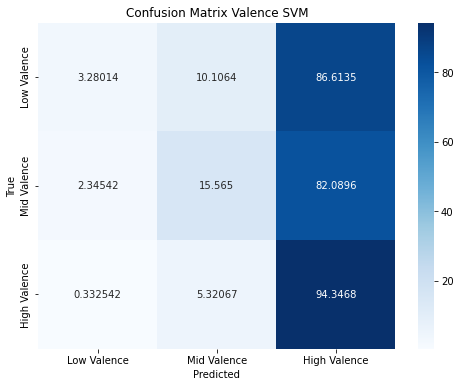

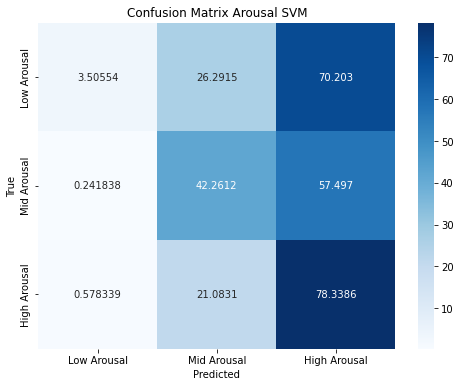

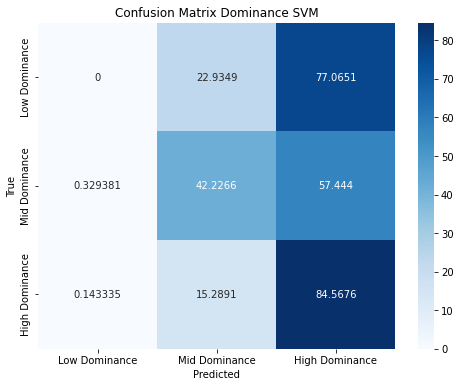

In [ ]:
cm_val_SVM = confusion_matrix(Valence_Test_Class[0:74240:16], val_class_SVM)
plt.figure(figsize=(8, 6))
row_sum_val_SVM = cm_val_SVM.sum(axis=1)
cm_val_percent_SVM = (cm_val_SVM / row_sum_val_SVM[:, np.newaxis]) * 100
sns.heatmap(cm_val_percent_SVM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Valence SVM')
class_names = ['Low Valence', 'Mid Valence', 'High Valence']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_aro_SVM = confusion_matrix(Arousal_Test_Class[0:74240:16], aro_class_SVM)
plt.figure(figsize=(8, 6))
row_sum_aro_SVM = cm_aro_SVM.sum(axis=1)
cm_aro_percent_SVM = (cm_aro_SVM / row_sum_aro_SVM[:, np.newaxis]) * 100
sns.heatmap(cm_aro_percent_SVM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Arousal SVM')
class_names = ['Low Arousal', 'Mid Arousal', 'High Arousal']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_dom_SVM = confusion_matrix(Domain_Test_Class[0:74240:16], dom_class_SVM)
plt.figure(figsize=(8, 6))
row_sum_dom_SVM = cm_dom_SVM.sum(axis=1)
cm_dom_percent_SVM = (cm_dom_SVM / row_sum_dom_SVM[:, np.newaxis]) * 100
sns.heatmap(cm_dom_percent_SVM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Dominance SVM')
class_names = ['Low Dominance', 'Mid Dominance', 'High Dominance']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [ ]:
report_val_SVM = classification_report(Valence_Test_Class[0:74240:16], val_class_SVM)
print("Classification Report Valence SVM:")
print(report_val_SVM)

report_aro_SVM = classification_report(Arousal_Test_Class[0:74240:16], aro_class_SVM)
print("Classification Report Arousal SVM:")
print(report_val_SVM)

report_dom_SVM = classification_report(Domain_Test_Class[0:74240:16], dom_class_SVM)
print("Classification Report Dominance SVM:")
print(report_dom_SVM)

Classification Report Valence SVM:
              precision    recall  f1-score   support

           0       0.48      0.03      0.06      1128
           1       0.49      0.16      0.24      1407
           2       0.48      0.94      0.64      2105

    accuracy                           0.48      4640
   macro avg       0.48      0.38      0.31      4640
weighted avg       0.48      0.48      0.38      4640

Classification Report Arousal SVM:
              precision    recall  f1-score   support

           0       0.48      0.03      0.06      1128
           1       0.49      0.16      0.24      1407
           2       0.48      0.94      0.64      2105

    accuracy                           0.48      4640
   macro avg       0.48      0.38      0.31      4640
weighted avg       0.48      0.48      0.38      4640

Classification Report Dominance SVM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1029
           1       0.5

In [ ]:
#predicciones clasificador XGB
val_class_XGB = Val_XGB.predict(M[0:74240:16])
aro_class_XGB = Aro_XGB.predict(M[0:74240:16])
dom_class_XGB = Dom_XGB.predict(M[0:74240:16])

acc_val_XGB = accuracy_score(Valence_Test_Class[0:74240:16], val_class_XGB)
acc_aro_XGB = accuracy_score(Arousal_Test_Class[0:74240:16], aro_class_XGB)
acc_dom_XGB = accuracy_score(Domain_Test_Class[0:74240:16], dom_class_XGB)

print("Valence XGBoost Accuracy: ", acc_val_XGB)
print("Valence XGBoost Accuracy: ", acc_aro_XGB)
print("Valence XGBoost Accuracy: ", acc_dom_XGB)


Valence XGBoost Accuracy:  0.7006465517241379
Valence XGBoost Accuracy:  0.7028017241379311
Valence XGBoost Accuracy:  0.7269396551724138


In [ ]:
report_val_XGB = classification_report(Valence_Test_Class[0:74240:16], val_class_XGB)
print("Classification Report Valence XGB:")
print(report_val_RF)

report_aro_XGB = classification_report(Arousal_Test_Class[0:74240:16], aro_class_XGB)
print("Classification Report Arousal XGB:")
print(report_val_XGB)

report_dom_XGB = classification_report(Domain_Test_Class[0:74240:16], dom_class_XGB)
print("Classification Report Dominance XGB:")
print(report_dom_XGB)

Classification Report Valence XGB:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1128
           1       0.91      0.86      0.88      1407
           2       0.87      0.95      0.91      2105

    accuracy                           0.89      4640
   macro avg       0.90      0.88      0.89      4640
weighted avg       0.89      0.89      0.89      4640

Classification Report Arousal XGB:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1128
           1       0.70      0.61      0.65      1407
           2       0.70      0.83      0.76      2105

    accuracy                           0.70      4640
   macro avg       0.70      0.67      0.68      4640
weighted avg       0.70      0.70      0.70      4640

Classification Report Dominance XGB:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62      1029
           1       0.7

In [19]:
'''
pickle.dump(Val_R, open('Val_R.pkl', 'wb'))
pickle.dump(Aro_R, open('Aro_R.pkl', 'wb'))
pickle.dump(Dom_R, open('Dom_R.pkl', 'wb'))
'''

pickle.dump(Val_RF, open('Val_RF_10s.pkl', 'wb'))
pickle.dump(Aro_RF, open('Aro_RF_10s.pkl', 'wb'))
pickle.dump(Dom_RF, open('Dom_RF_10s.pkl', 'wb'))

(array([16704., 26796., 50808., 48372., 26100., 69948., 68556., 58812.,
        41064., 38280.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

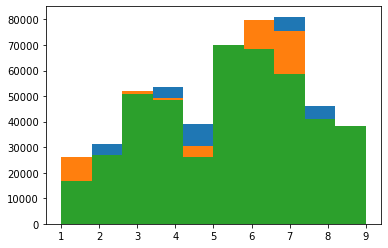

In [21]:
plt.hist(Arousal_Train)
plt.hist(Valence_Train)
plt.hist(Domain_Train)

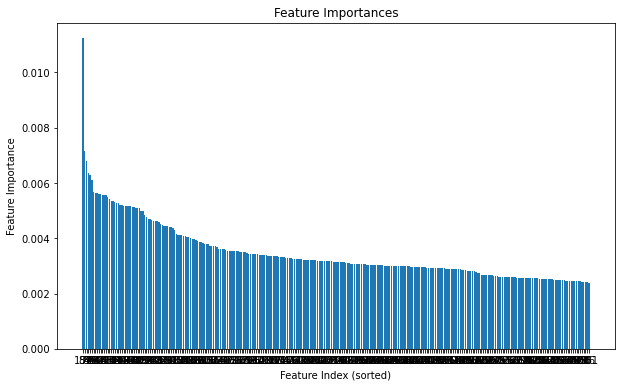

In [37]:
importances_Aro_o = Aro_RF.feature_importances_
indices = np.argsort(importances_Aro_o)[::-1]
sorted_importances = importances_Aro_o[indices]

# Plotting histogram of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(df[0:468480:16].shape[1]), sorted_importances)
plt.xticks(range(df[0:468480:16].shape[1]), indices)
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [38]:
fts=10

importances_Val = Val_RF.feature_importances_
indices_Val = np.argsort(importances_Val)[::-1]
sorted_importances_Val = importances_Val[indices_Val][:fts]
top_indices_Val = indices_Val[:fts]

importances_Aro = Aro_RF.feature_importances_
indices_Aro = np.argsort(importances_Aro)[::-1]
sorted_importances_Aro = importances_Aro[indices_Aro][:fts]
top_indices_Aro = indices_Aro[:fts]

importances_Dom = Dom_RF.feature_importances_
indices_Dom = np.argsort(importances_Dom)[::-1]
sorted_importances_Dom = importances_Dom[indices_Dom][:fts]
top_indices_Dom = indices_Dom[:fts]

Val_top20 = df.iloc[:, top_indices_Val]
Val_top20_pred = df_pred.iloc[:, top_indices_Val]

Aro_top20 = df.iloc[:, top_indices_Aro]
Aro_top20_pred = df_pred.iloc[:, top_indices_Aro]

Dom_top20 = df.iloc[:, top_indices_Dom]
Dom_top20_pred = df_pred.iloc[:, top_indices_Dom]
#Entrenamiento de Clasificadores RF

Val_RF_20 = RandomForestClassifier(n_estimators=512, n_jobs=6)
Val_RF_20.fit(Val_top20[0:468480:16], Valence_Train_Class[0:468480:16])

Aro_RF_20 = RandomForestClassifier(n_estimators=512, n_jobs=6)
Aro_RF_20.fit(Aro_top20[0:468480:16], Arousal_Train_Class[0:468480:16])

Dom_RF_20 = RandomForestClassifier(n_estimators=512, n_jobs=6)
Dom_RF_20.fit(Dom_top20[0:468480:16], Domain_Train_Class[0:468480:16])

RandomForestClassifier(n_estimators=512, n_jobs=6)

In [39]:
#predicciones clasificador
val_class_RF_20 = Val_RF_20.predict(Val_top20_pred[0:74240:16])
aro_class_RF_20 = Aro_RF_20.predict(Aro_top20_pred[0:74240:16])
dom_class_RF_20 = Dom_RF_20.predict(Dom_top20_pred[0:74240:16])

acc_val_RF_20 = accuracy_score(Valence_Test_Class[0:74240:16], val_class_RF_20)
acc_aro_RF_20 = accuracy_score(Arousal_Test_Class[0:74240:16], aro_class_RF_20)
acc_dom_RF_20 = accuracy_score(Domain_Test_Class[0:74240:16], dom_class_RF_20)

print("Valence Random Forest Accuracy Top 20 Features: ", acc_val_RF_20)
print("Arousal Random Forest Accuracy Top 20 Features: ", acc_aro_RF_20)
print("Dominance Random Forest Accuracy Top 20 Features: ", acc_dom_RF_20)

Valence Random Forest Accuracy Top 20 Features:  0.8935344827586207
Arousal Random Forest Accuracy Top 20 Features:  0.8674568965517241
Dominance Random Forest Accuracy Top 20 Features:  0.9038793103448276


In [41]:
report_val_RF_20 = classification_report(Valence_Test_Class[0:74240:16], val_class_RF_20)
print("Classification Report Valence Random Forest Top 20:")
print(report_val_RF_20)

report_aro_RF_20 = classification_report(Arousal_Test_Class[0:74240:16], aro_class_RF_20)
print("Classification Report Arousal Random Forest Top 20:")
print(report_aro_RF_20)

report_dom_RF_20 = classification_report(Domain_Test_Class[0:74240:16], dom_class_RF_20)
print("Classification Report Dominance Random Forest Top 20:")
print(report_dom_RF_20)

Classification Report Valence Random Forest Top 20:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1128
           1       0.90      0.87      0.88      1407
           2       0.88      0.95      0.91      2105

    accuracy                           0.89      4640
   macro avg       0.90      0.88      0.89      4640
weighted avg       0.90      0.89      0.89      4640

Classification Report Arousal Random Forest Top 20:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1084
           1       0.87      0.86      0.87      1654
           2       0.85      0.91      0.88      1902

    accuracy                           0.87      4640
   macro avg       0.87      0.86      0.86      4640
weighted avg       0.87      0.87      0.87      4640

Classification Report Dominance Random Forest Top 20:
              precision    recall  f1-score   support

           0       0.93  

([<matplotlib.axis.YTick at 0x2099606e1c0>,
 [Text(0, 0.5, 'Low Dominance'),
  Text(0, 1.5, 'Mid Dominance'),
  Text(0, 2.5, 'High Dominance')])

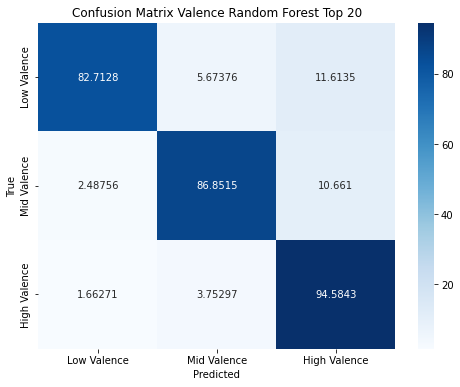

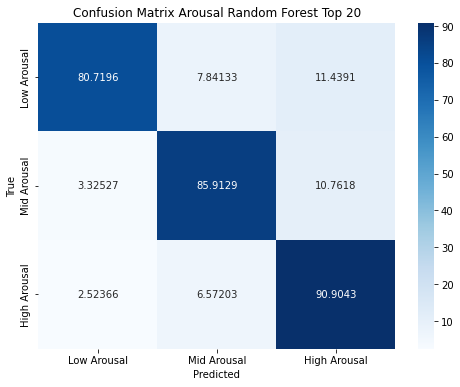

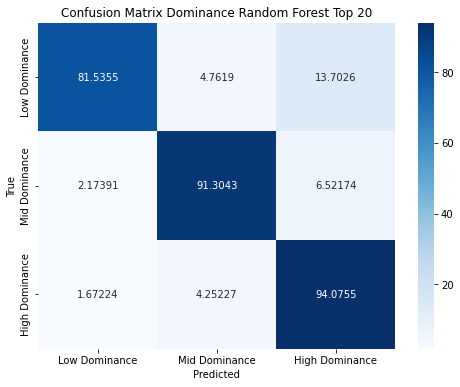

In [42]:
cm_val_RF_20 = confusion_matrix(Valence_Test_Class[0:74240:16], val_class_RF_20)
plt.figure(figsize=(8, 6))
row_sum_val_RF_20 = cm_val_RF_20.sum(axis=1)
cm_val_percent_RF_20 = (cm_val_RF_20 / row_sum_val_RF_20[:, np.newaxis]) * 100
sns.heatmap(cm_val_percent_RF_20, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Valence Random Forest Top 20')
class_names = ['Low Valence', 'Mid Valence', 'High Valence']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_aro_RF_20 = confusion_matrix(Arousal_Test_Class[0:74240:16], aro_class_RF_20)
plt.figure(figsize=(8, 6))
row_sum_aro_RF_20 = cm_aro_RF_20.sum(axis=1)
cm_aro_percent_RF_20 = (cm_aro_RF_20 / row_sum_aro_RF_20[:, np.newaxis]) * 100
sns.heatmap(cm_aro_percent_RF_20, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Arousal Random Forest Top 20')
class_names = ['Low Arousal', 'Mid Arousal', 'High Arousal']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cm_dom_RF_20 = confusion_matrix(Domain_Test_Class[0:74240:16], dom_class_RF_20)
plt.figure(figsize=(8, 6))
row_sum_dom_RF_20 = cm_dom_RF_20.sum(axis=1)
cm_dom_percent_RF_20 = (cm_dom_RF_20 / row_sum_dom_RF_20[:, np.newaxis]) * 100
sns.heatmap(cm_dom_percent_RF_20, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Dominance Random Forest Top 20')
class_names = ['Low Dominance', 'Mid Dominance', 'High Dominance']
tick_marks = [0.5, 1.5, 2.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

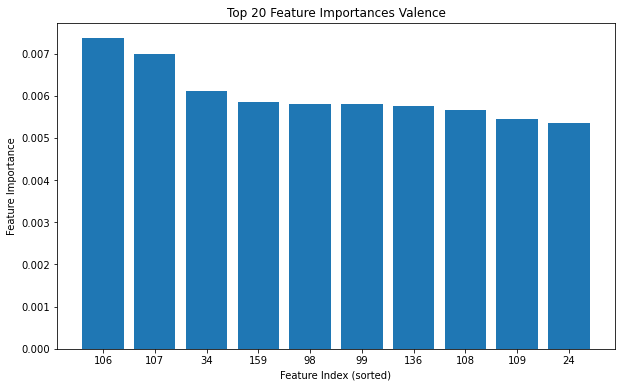

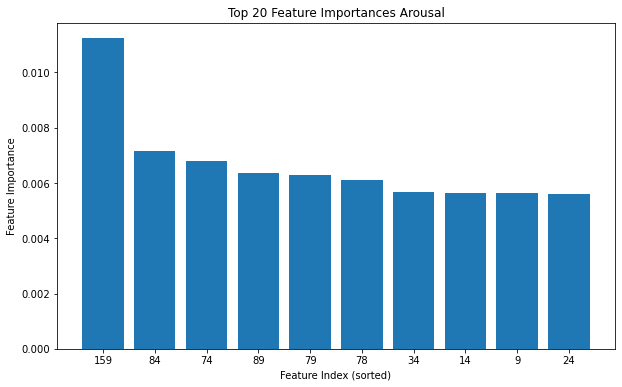

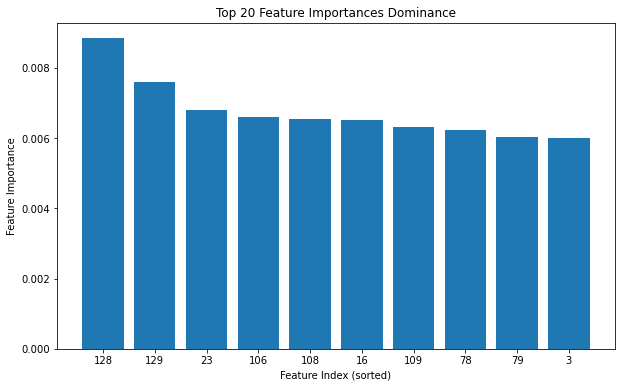

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(range(fts), sorted_importances_Val)
plt.xticks(range(fts), top_indices_Val)
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Feature Importance')
plt.title('Top 20 Feature Importances Valence')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(fts), sorted_importances_Aro)
plt.xticks(range(fts), top_indices_Aro)
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Feature Importance')
plt.title('Top 20 Feature Importances Arousal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(fts), sorted_importances_Dom)
plt.xticks(range(fts), top_indices_Dom)
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Feature Importance')
plt.title('Top 20 Feature Importances Dominance')
plt.show()